# 📉 Autoencoders (AE)

Welcome to the first notebook in our exploration of **Generative Models**!

We start with **Autoencoders (AEs)**. An Autoencoder is a type of neural network designed to learn efficient, compressed representations of data, known as the **latent space**.

### The Core Idea: Self-Supervised Learning
Autoencoders operate in a **self-supervised** manner. They are trained to perform an identity function: map the input ($\mathbf{x}$) to the output ($\mathbf{x'}$), but with a crucial constraint.

**Constraint:** The internal layer (the bottleneck) must force the network to compress the information, learning only the most salient features necessary for reconstruction.

### Key Applications
1.  **Dimensionality Reduction:** Compressing high-dimensional data (like images) into a small feature vector.
2.  **Denoising:** Removing noise or artifacts from input data (which we will demonstrate).
3.  **Feature Extraction:** Learning rich, compact features that can be used as input for other machine learning tasks.

## 1. Architecture Deep Dive

An Autoencoder is composed of three parts:

![autoencoder architecture](https://www.ibm.com/content/dam/connectedassets-adobe-cms/worldwide-content/creative-assets/s-migr/ul/g/b6/f4/variational-autoencoder-neural-network.png)

### 1. The Encoder
The encoder is a network that gradually reduces the spatial dimensions of the input while increasing the feature complexity (channels). It maps the input $\mathbf{x}$ to the latent representation $\mathbf{z}$:

$$\mathbf{z} = \text{Encoder}(\mathbf{x})$$

### 2. The Latent Space (Bottleneck)
This is the compressed, dense representation ($\mathbf{z}$). It acts as the information filter. By keeping this space small, the network is forced to learn only the most important features of the input data.

For an image of size $28 \times 28 \times 1$, the latent vector $\mathbf{z}$ might only be 64 numbers long.

### 3. The Decoder
The decoder is a network that mirrors the encoder. It takes the compressed latent vector $\mathbf{z}$ and reconstructs the original input $\mathbf{x'}$:

$$\mathbf{x'} = \text{Decoder}(\mathbf{z})$$

### The Loss Function
The model is trained using **Reconstruction Loss**, which is typically the **Mean Squared Error (MSE)** between the input $\mathbf{x}$ and the reconstructed output $\mathbf{x'}$:

$$\mathcal{L} = ||\mathbf{x} - \mathbf{x'}||^2$$

## 2. Setup and Convolutional Autoencoder (CAE) Implementation

Since we are working with images (MNIST), we will use a **Convolutional Autoencoder (CAE)**, which leverages CNN layers for more effective feature extraction.

The decoder will use **Transposed Convolutional layers** (`nn.ConvTranspose2d`) to perform learned upsampling.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- 1. Define the Architecture ---

class Autoencoder(nn.Module):
    def __init__(self, latent_dim=128):
        super(Autoencoder, self).__init__()

        # --- Encoder ---
        self.encoder = nn.Sequential(
            # Input: 1 x 28 x 28
            nn.Conv2d(1, 16, kernel_size=3, padding=1), # 16 x 28 x 28
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),                  # 16 x 14 x 14
            nn.Conv2d(16, 32, kernel_size=3, padding=1), # 32 x 14 x 14
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),                  # 32 x 7 x 7
            # Flatten to latent vector
            nn.Flatten()
        )

        # --- Bottleneck/Latent Space ---
        # 32 * 7 * 7 = 1568 features before the final linear compression
        self.fc_encode = nn.Linear(32 * 7 * 7, latent_dim)

        # --- Decoder setup (map latent vector back to feature map) ---
        self.fc_decode = nn.Linear(latent_dim, 32 * 7 * 7)

        # --- Decoder ---
        self.decoder = nn.Sequential(
            # Unflattened input: 32 x 7 x 7
            # Transposed Conv (Deconvolution) is used for learned upsampling
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1), # 16 x 14 x 14
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # 1 x 28 x 28
            nn.Sigmoid() # Sigmoid to ensure output pixels are between 0 and 1
        )

    def forward(self, x):
        batch_size = x.size(0)

        # 1. Encode
        x = self.encoder(x)

        # 2. Bottleneck (Compress)
        z = self.fc_encode(x)

        # 3. Decoder Prep (Expand)
        x = self.fc_decode(z)
        x = x.view(batch_size, 32, 7, 7) # Reshape back to feature map

        # 4. Decode
        x_prime = self.decoder(x)
        return x_prime, z

Using device: cuda


## 3. Data Loading (MNIST) and Training

We will use the standard MNIST handwritten digits dataset. We normalize the images to ensure pixel values are between 0 and 1, which is compatible with our final `nn.Sigmoid()` activation and the MSE loss.

In [2]:
# --- 2. Data Loading ---
transform = transforms.Compose([
    transforms.ToTensor(), # Converts to [0, 1] range
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# --- 3. Training Setup ---
model = Autoencoder(latent_dim=64).to(device) # We use a 64-dimensional latent vector
criterion = nn.MSELoss() # Reconstruction Loss: Mean Squared Error
optimizer = optim.Adam(model.parameters(), lr=1e-3)

N_EPOCHS = 10
print(f"Starting training for {N_EPOCHS} epochs...")

# --- 4. Training Loop ---
for epoch in range(N_EPOCHS):
    model.train()
    train_loss = 0

    for data in train_loader:
        img, _ = data
        img = img.to(device)

        # The input is the target (self-supervised)
        target = img.clone().detach()

        optimizer.zero_grad()

        output, _ = model(img)
        loss = criterion(output, target)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    # --- Evaluation ---
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data in test_loader:
            img, _ = data
            img = img.to(device)
            target = img.clone().detach()

            output, _ = model(img)
            test_loss += criterion(output, target).item()

    avg_test_loss = test_loss / len(test_loader)

    print(f'Epoch {epoch+1}/{N_EPOCHS}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

print("Training complete.")

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 455kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.49MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.08MB/s]


Starting training for 10 epochs...
Epoch 1/10, Train Loss: 0.0389, Test Loss: 0.0125
Epoch 2/10, Train Loss: 0.0098, Test Loss: 0.0077
Epoch 3/10, Train Loss: 0.0068, Test Loss: 0.0059
Epoch 4/10, Train Loss: 0.0055, Test Loss: 0.0049
Epoch 5/10, Train Loss: 0.0047, Test Loss: 0.0043
Epoch 6/10, Train Loss: 0.0042, Test Loss: 0.0039
Epoch 7/10, Train Loss: 0.0039, Test Loss: 0.0036
Epoch 8/10, Train Loss: 0.0036, Test Loss: 0.0035
Epoch 9/10, Train Loss: 0.0034, Test Loss: 0.0033
Epoch 10/10, Train Loss: 0.0033, Test Loss: 0.0031
Training complete.


## 4. Evaluation and Visualization: Reconstruction

Let's visualize how well the network can reconstruct digits it hasn't seen before.

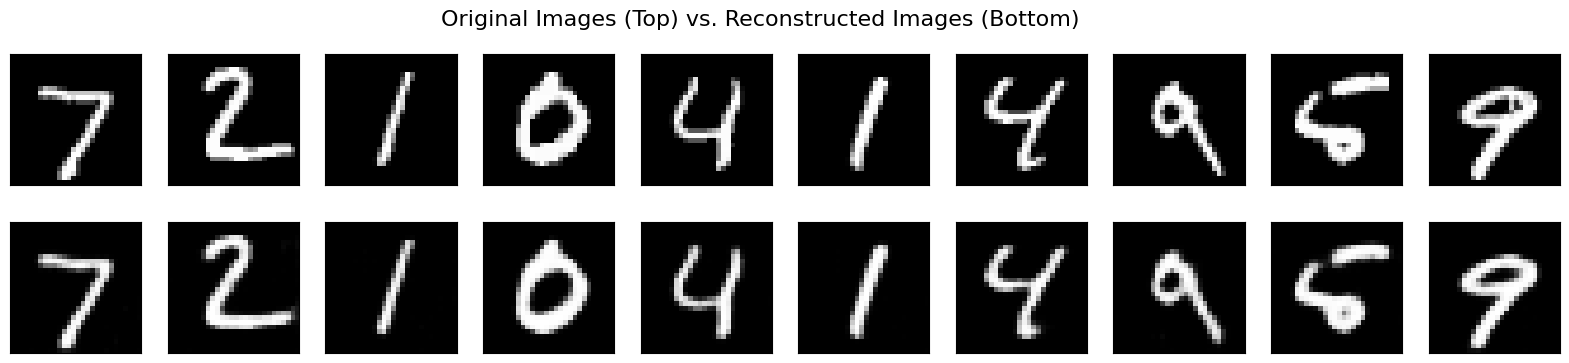

In [3]:
# Get a batch of test data
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Pass through the model
with torch.no_grad():
    images = images.to(device)
    reconstructed_images, _ = model(images)

# Convert to CPU for plotting
images = images.cpu().numpy()
reconstructed_images = reconstructed_images.cpu().numpy()

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original Images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstructed Images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_images[i].squeeze(), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.suptitle("Original Images (Top) vs. Reconstructed Images (Bottom)", fontsize=16)
plt.show()

## 5. Practical Application: Denoising Autoencoder

A key strength of AEs is their ability to perform **Denoising**.

When we train a Denoising Autoencoder (DAE), we intentionally feed a **corrupted** input ($\mathbf{\tilde{x}}$) but set the reconstruction target as the **original, clean** input ($\mathbf{x}$).

The network is forced to learn how to **undo the corruption** using only the essential features captured in the bottleneck.

$$\mathcal{L} = ||\mathbf{x} - \text{Decoder}(\text{Encoder}(\mathbf{\tilde{x}}))||^2$$

In [4]:
# --- Denoising Setup ---
# Function to add random Gaussian noise
def add_noise(img):
    # Ensure tensor is on CPU before converting to numpy for noise addition
    img_np = img.cpu().numpy()

    # Add Gaussian noise
    noise = np.random.normal(0, 0.5, img_np.shape)
    noisy_img_np = img_np + noise

    # Clip values back to [0, 1] range
    noisy_img_np = np.clip(noisy_img_np, 0., 1.)

    # Convert back to tensor and move to device
    return torch.from_numpy(noisy_img_np).float().to(device)

# --- Training Loop for Denoising ---
model_denoise = Autoencoder(latent_dim=64).to(device)
optimizer_denoise = optim.Adam(model_denoise.parameters(), lr=1e-3)
criterion_denoise = nn.MSELoss()

N_EPOCHS_DENOISE = 10
print(f"\nStarting Denoising AE training for {N_EPOCHS_DENOISE} epochs...")

for epoch in range(N_EPOCHS_DENOISE):
    model_denoise.train()
    train_loss = 0

    for data in train_loader:
        img, _ = data
        img = img.to(device)

        # 1. Create Noisy Input
        noisy_img = add_noise(img)

        # 2. Target is the Clean Image
        target = img.clone().detach()

        optimizer_denoise.zero_grad()

        output, _ = model_denoise(noisy_img) # Feed NOISY
        loss = criterion_denoise(output, target) # Compare to CLEAN

        loss.backward()
        optimizer_denoise.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{N_EPOCHS_DENOISE}, Train Loss: {avg_train_loss:.4f}')

print("Denoising training complete.")


Starting Denoising AE training for 10 epochs...
Epoch 1/10, Train Loss: 0.0501
Epoch 2/10, Train Loss: 0.0198
Epoch 3/10, Train Loss: 0.0158
Epoch 4/10, Train Loss: 0.0142
Epoch 5/10, Train Loss: 0.0133
Epoch 6/10, Train Loss: 0.0127
Epoch 7/10, Train Loss: 0.0123
Epoch 8/10, Train Loss: 0.0120
Epoch 9/10, Train Loss: 0.0117
Epoch 10/10, Train Loss: 0.0116
Denoising training complete.


## 6. Evaluation: Denoising Results

We will now pass the noisy images through the Denoising Autoencoder to see how effectively it cleans the data.

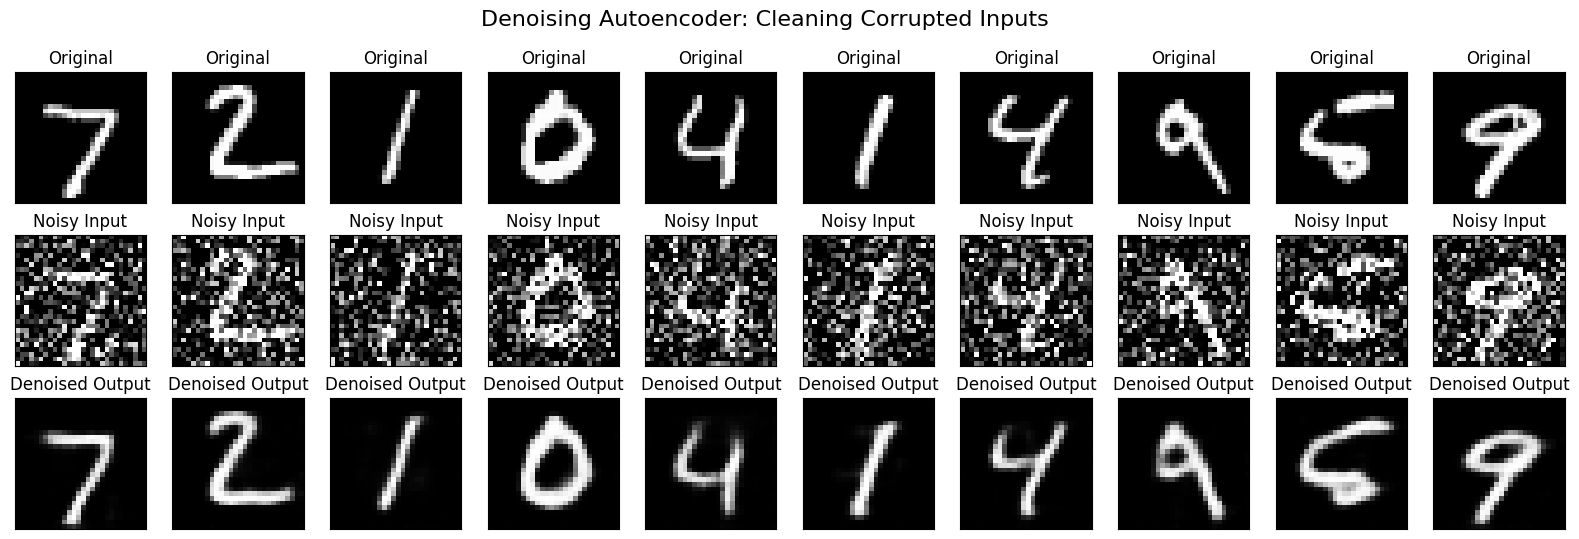

In [5]:
# Get a batch of test data
dataiter_denoise = iter(test_loader)
images_clean, _ = next(dataiter_denoise)

# Create the noisy input batch
images_noisy = add_noise(images_clean.to(device))

# Pass through the Denoising model
model_denoise.eval()
with torch.no_grad():
    images_denoised, _ = model_denoise(images_noisy)

# Convert to CPU for plotting
images_clean_np = images_clean.cpu().numpy()
images_noisy_np = images_noisy.cpu().numpy()
images_denoised_np = images_denoised.cpu().numpy()

n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # Row 1: Original Clean Images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(images_clean_np[i].squeeze(), cmap='gray')
    ax.set_title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Row 2: Noisy Input Images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(images_noisy_np[i].squeeze(), cmap='gray')
    ax.set_title("Noisy Input")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Row 3: Denoised Output Images
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(images_denoised_np[i].squeeze(), cmap='gray')
    ax.set_title("Denoised Output")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.suptitle("Denoising Autoencoder: Cleaning Corrupted Inputs", fontsize=16)
plt.show()

## 7. Conclusion and Next Steps

We successfully built a **Convolutional Autoencoder (CAE)** and demonstrated its ability to learn compressed features, enabling high-quality image reconstruction and powerful **denoising**.

However, standard Autoencoders have a weakness: the latent space ($\mathbf{z}$) is often disorganized. If we sample a random point from this space, the decoder usually produces meaningless noise, not a coherent image. This limits its use as a truly **generative** model.

In the next notebook, we will fix this issue by introducing the **Variational Autoencoder (VAE)**, which forces the latent space to follow a smooth, structured probability distribution.